# Project Title

* Flight Fare Prediction

# Description

* Flight ticket prices vary significantly based on factors such as airline, route, duration, stops, and departure/arrival times, making manual price estimation unreliable.The objective is to build a machine learning regression model that accurately predicts flight fares using historical flight and journey-related data.The solution should handle real-world data challenges and provide reliable predictions to support pricing analysis and decision-making.

# Importing Basic Libraries

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Data Visualization Libraries
import seaborn as snsw
import matplotlib.pyplot as plt

# Data Processing Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Evaluation Libraries
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,accuracy_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Hyperparameter Optimization Libraries
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import keras_tuner as kt

In [3]:
df=pd.read_excel("Flight_Fare.xlsx")

In [4]:
pd.set_option("display.max_columns",None)

In [5]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


# Basic Checks

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [7]:
print(df['Airline'].unique())
print(df['Source'].unique())
print(df['Destination'].unique())

['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']
['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']


# Feature Engineering

In [8]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')

In [9]:
df['Journey_day'] = df['Date_of_Journey'].dt.day
df['Journey_month'] = df['Date_of_Journey'].dt.month
df['Journey_year'] = df['Date_of_Journey'].dt.year

In [10]:
df['Journey_year'].unique()

array([2019], dtype=int32)

In [11]:
df.drop(columns=['Date_of_Journey','Journey_year'], inplace=True)

In [12]:
df['Additional_Info'].value_counts()

Additional_Info
No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

In [13]:
df.drop(columns=['Additional_Info'], inplace=True)

In [14]:
df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops'],
      dtype=object)

In [15]:
df['Total_Stops'].isna().sum()

np.int64(1)

In [16]:
df['Total_Stops'].fillna(df['Total_Stops'].mode()[0], inplace=True)

In [17]:
df['Total_Stops'] = df['Total_Stops'].map({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4})

In [18]:
df['Duration'] = (
    df['Duration'].str.extract(r'(\d+)h')[0].fillna(0).astype(int) * 60 +
    df['Duration'].str.extract(r'(\d+)m')[0].fillna(0).astype(int)
)

In [19]:
df["Arrival_Time"] = df["Arrival_Time"].astype(str)

time_mask = df["Arrival_Time"].str.match(r"^\d{1,2}:\d{2}$")

df.loc[time_mask, "datetime"] = pd.to_datetime(
    df.loc[time_mask, "Journey_month"].astype(str).str.zfill(2) + "-" +
    df.loc[time_mask, "Journey_day"].astype(str).str.zfill(2) + " " +
    df.loc[time_mask, "Arrival_Time"],
    format="%m-%d %H:%M"
)

df.loc[~time_mask, "datetime"] = pd.to_datetime(
    df.loc[~time_mask, "Arrival_Time"],
    format="mixed",
    errors="coerce"
)

df["Arrival_hour"] = df["datetime"].dt.hour
df["Arrival_minute"] = df["datetime"].dt.minute
df["Arrival_day"] = df["datetime"].dt.day
df["Arrival_month"] = df["datetime"].dt.month

In [20]:
df.drop(columns=['datetime','Arrival_Time'],inplace=True)

In [21]:
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'], format='%H:%M')
df['Dep_hour'] = df['Dep_Time'].dt.hour
df['Dep_minute'] = df['Dep_Time'].dt.minute
df.drop(columns=['Dep_Time'],inplace=True)

In [22]:
df["Route_Legs"] = df["Route"].str.count("→") + 1
df["Route_Legs"] = df["Route_Legs"].fillna(1).astype(int)

df["Main_Layover"] = (df["Route"].fillna("Direct").str.split("→").apply(lambda x: x[1] if len(x) > 2 else "Direct"))

df.drop(['Route'], axis=1, inplace=True)

In [23]:
top_layovers = df["Main_Layover"].value_counts().nlargest(5).index

df["Main_Layover"] = df["Main_Layover"].where(df["Main_Layover"].isin(top_layovers),"Other")

In [24]:
cat_cols = ['Airline', 'Source', 'Destination', 'Main_Layover']

df = pd.get_dummies(df, columns=cat_cols, drop_first=True,dtype=int)

In [25]:
df.columns

Index(['Duration', 'Total_Stops', 'Price', 'Journey_day', 'Journey_month',
       'Arrival_hour', 'Arrival_minute', 'Arrival_day', 'Arrival_month',
       'Dep_hour', 'Dep_minute', 'Route_Legs', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi', 'Main_Layover_ BOM ',
       'Main_Layover_ DEL ', 'Main_Layover_ HYD ', 'Main_Layover_Direct',
       'Main_Layover_Other'],
      dtype='object')

# Exploratory Data Analysis

In [26]:
num_cols=['Duration','Journey_day', 'Journey_month',
       'Arrival_hour', 'Arrival_minute', 'Arrival_day', 'Arrival_month',
       'Dep_hour', 'Dep_minute']

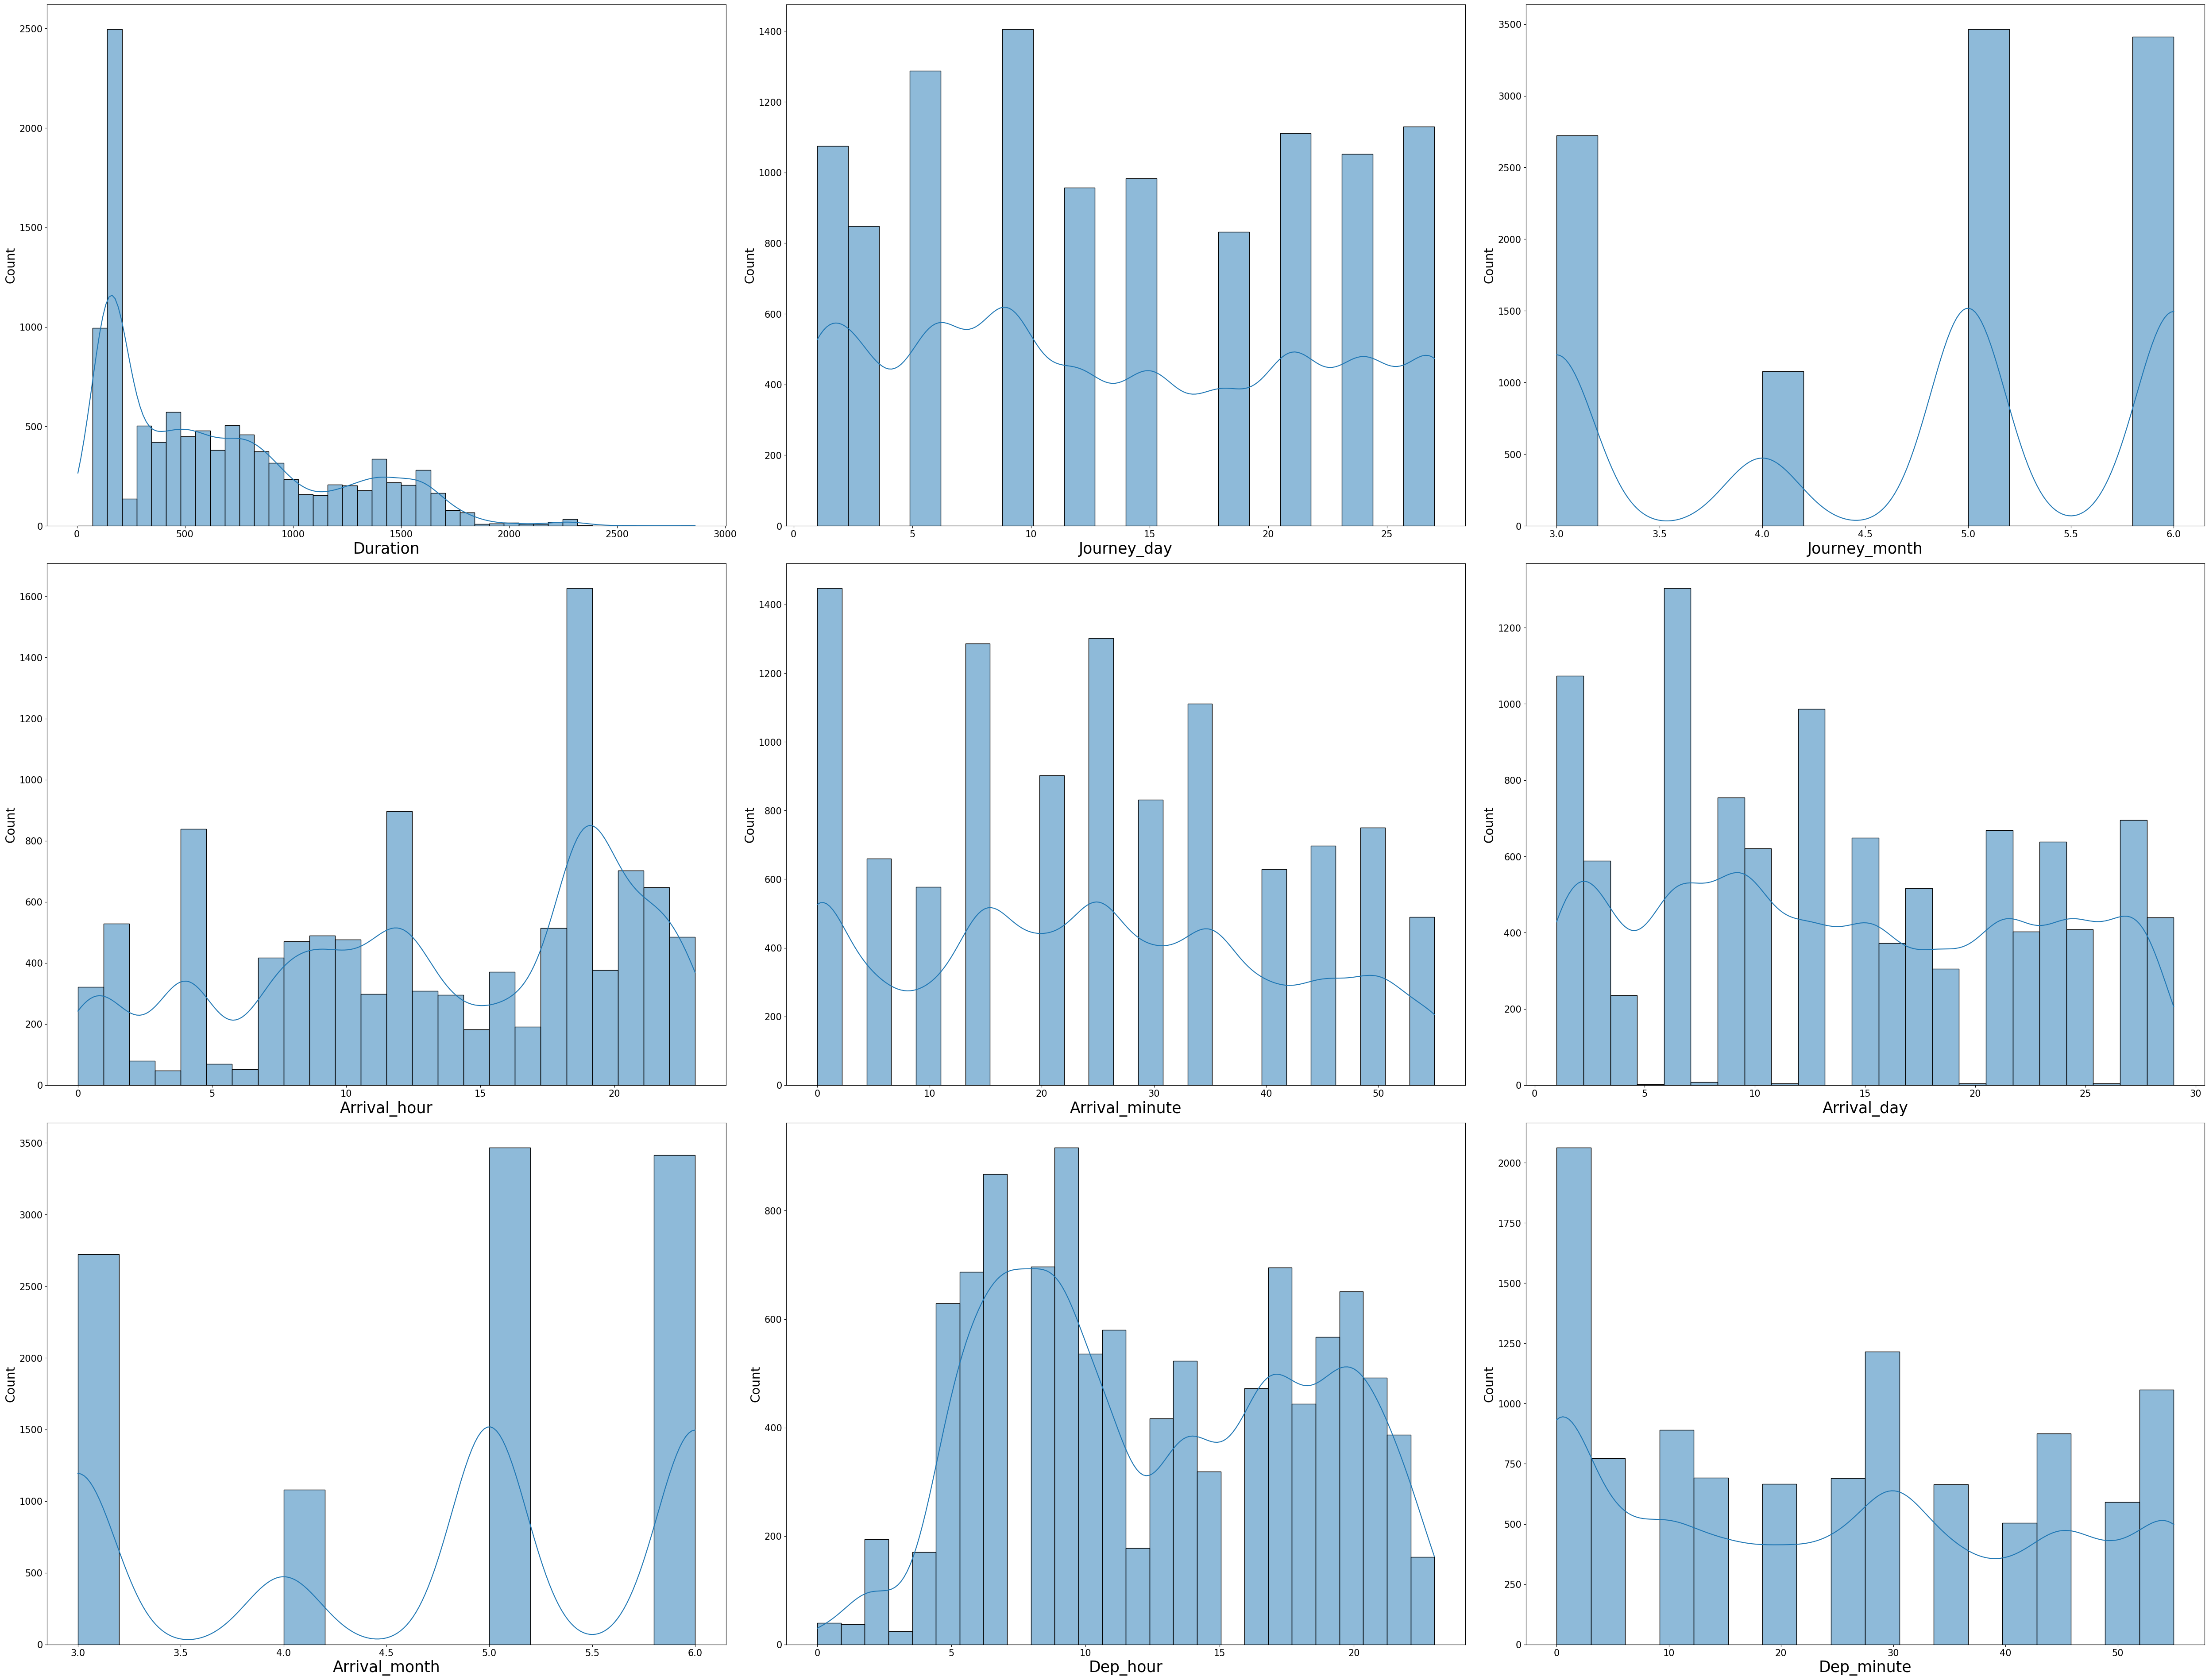

In [27]:
plt.figure(figsize=(50,50))
plot_num = 1

for col in num_cols:
    if plot_num <= 12:
        plt.subplot(4,3,plot_num)
        sns.histplot(df[col],kde=True)
        plt.xlabel(col,fontsize=25)
        plt.ylabel("Count",fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
    plot_num = plot_num+1
plt.tight_layout()

In [28]:
df['Duration'].skew()

np.float64(0.8610740526194615)

<Axes: xlabel='Duration', ylabel='Count'>

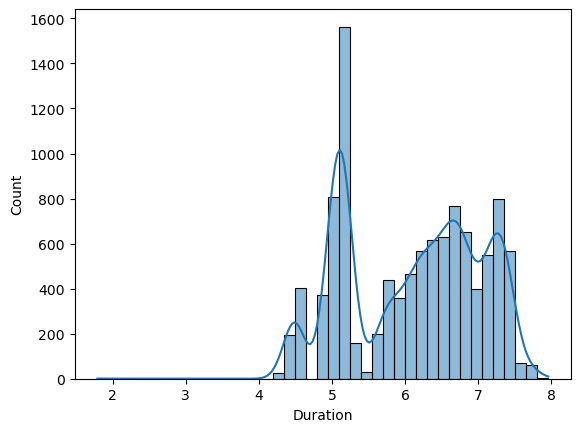

In [29]:
df['Duration'] = np.log1p(df['Duration'])  
sns.histplot(df['Duration'],kde=True)

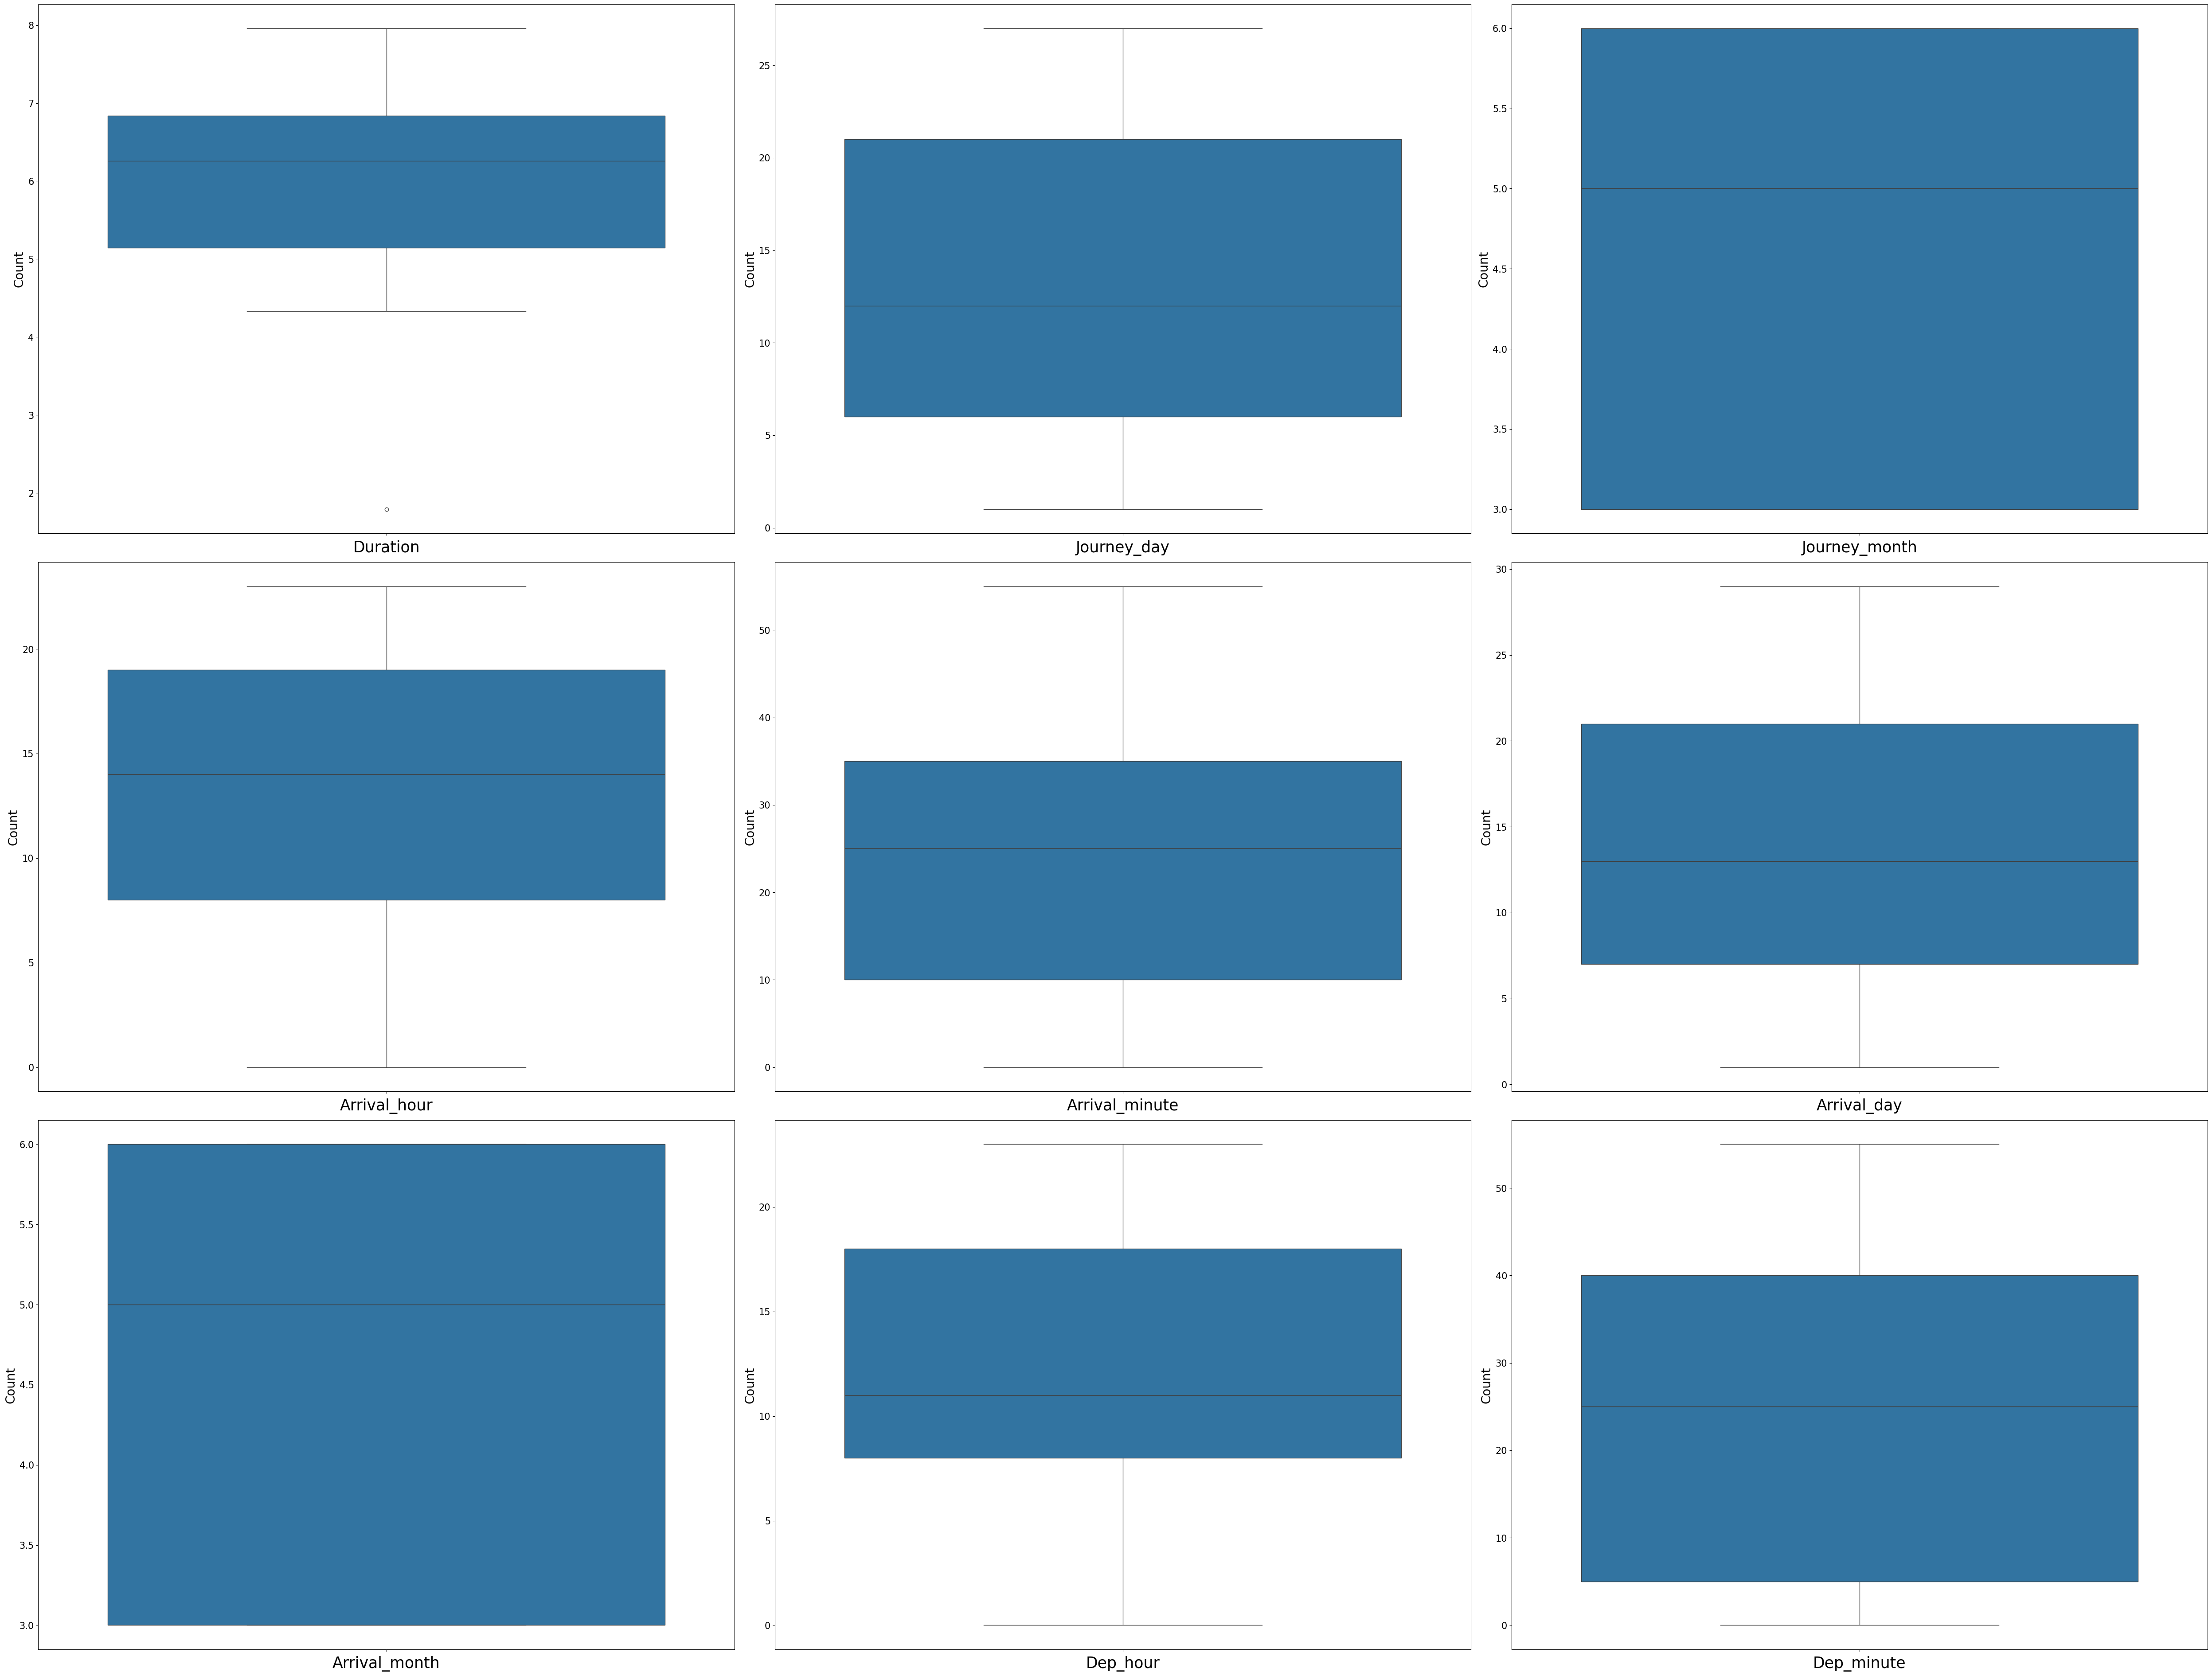

In [30]:
plt.figure(figsize=(50,50))
plot_num = 1

for col in num_cols:
    if plot_num <= 12:
        plt.subplot(4,3,plot_num)
        sns.boxplot(df[col])
        plt.xlabel(col,fontsize=25)
        plt.ylabel("Count",fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
    plot_num = plot_num+1
plt.tight_layout()

<Axes: >

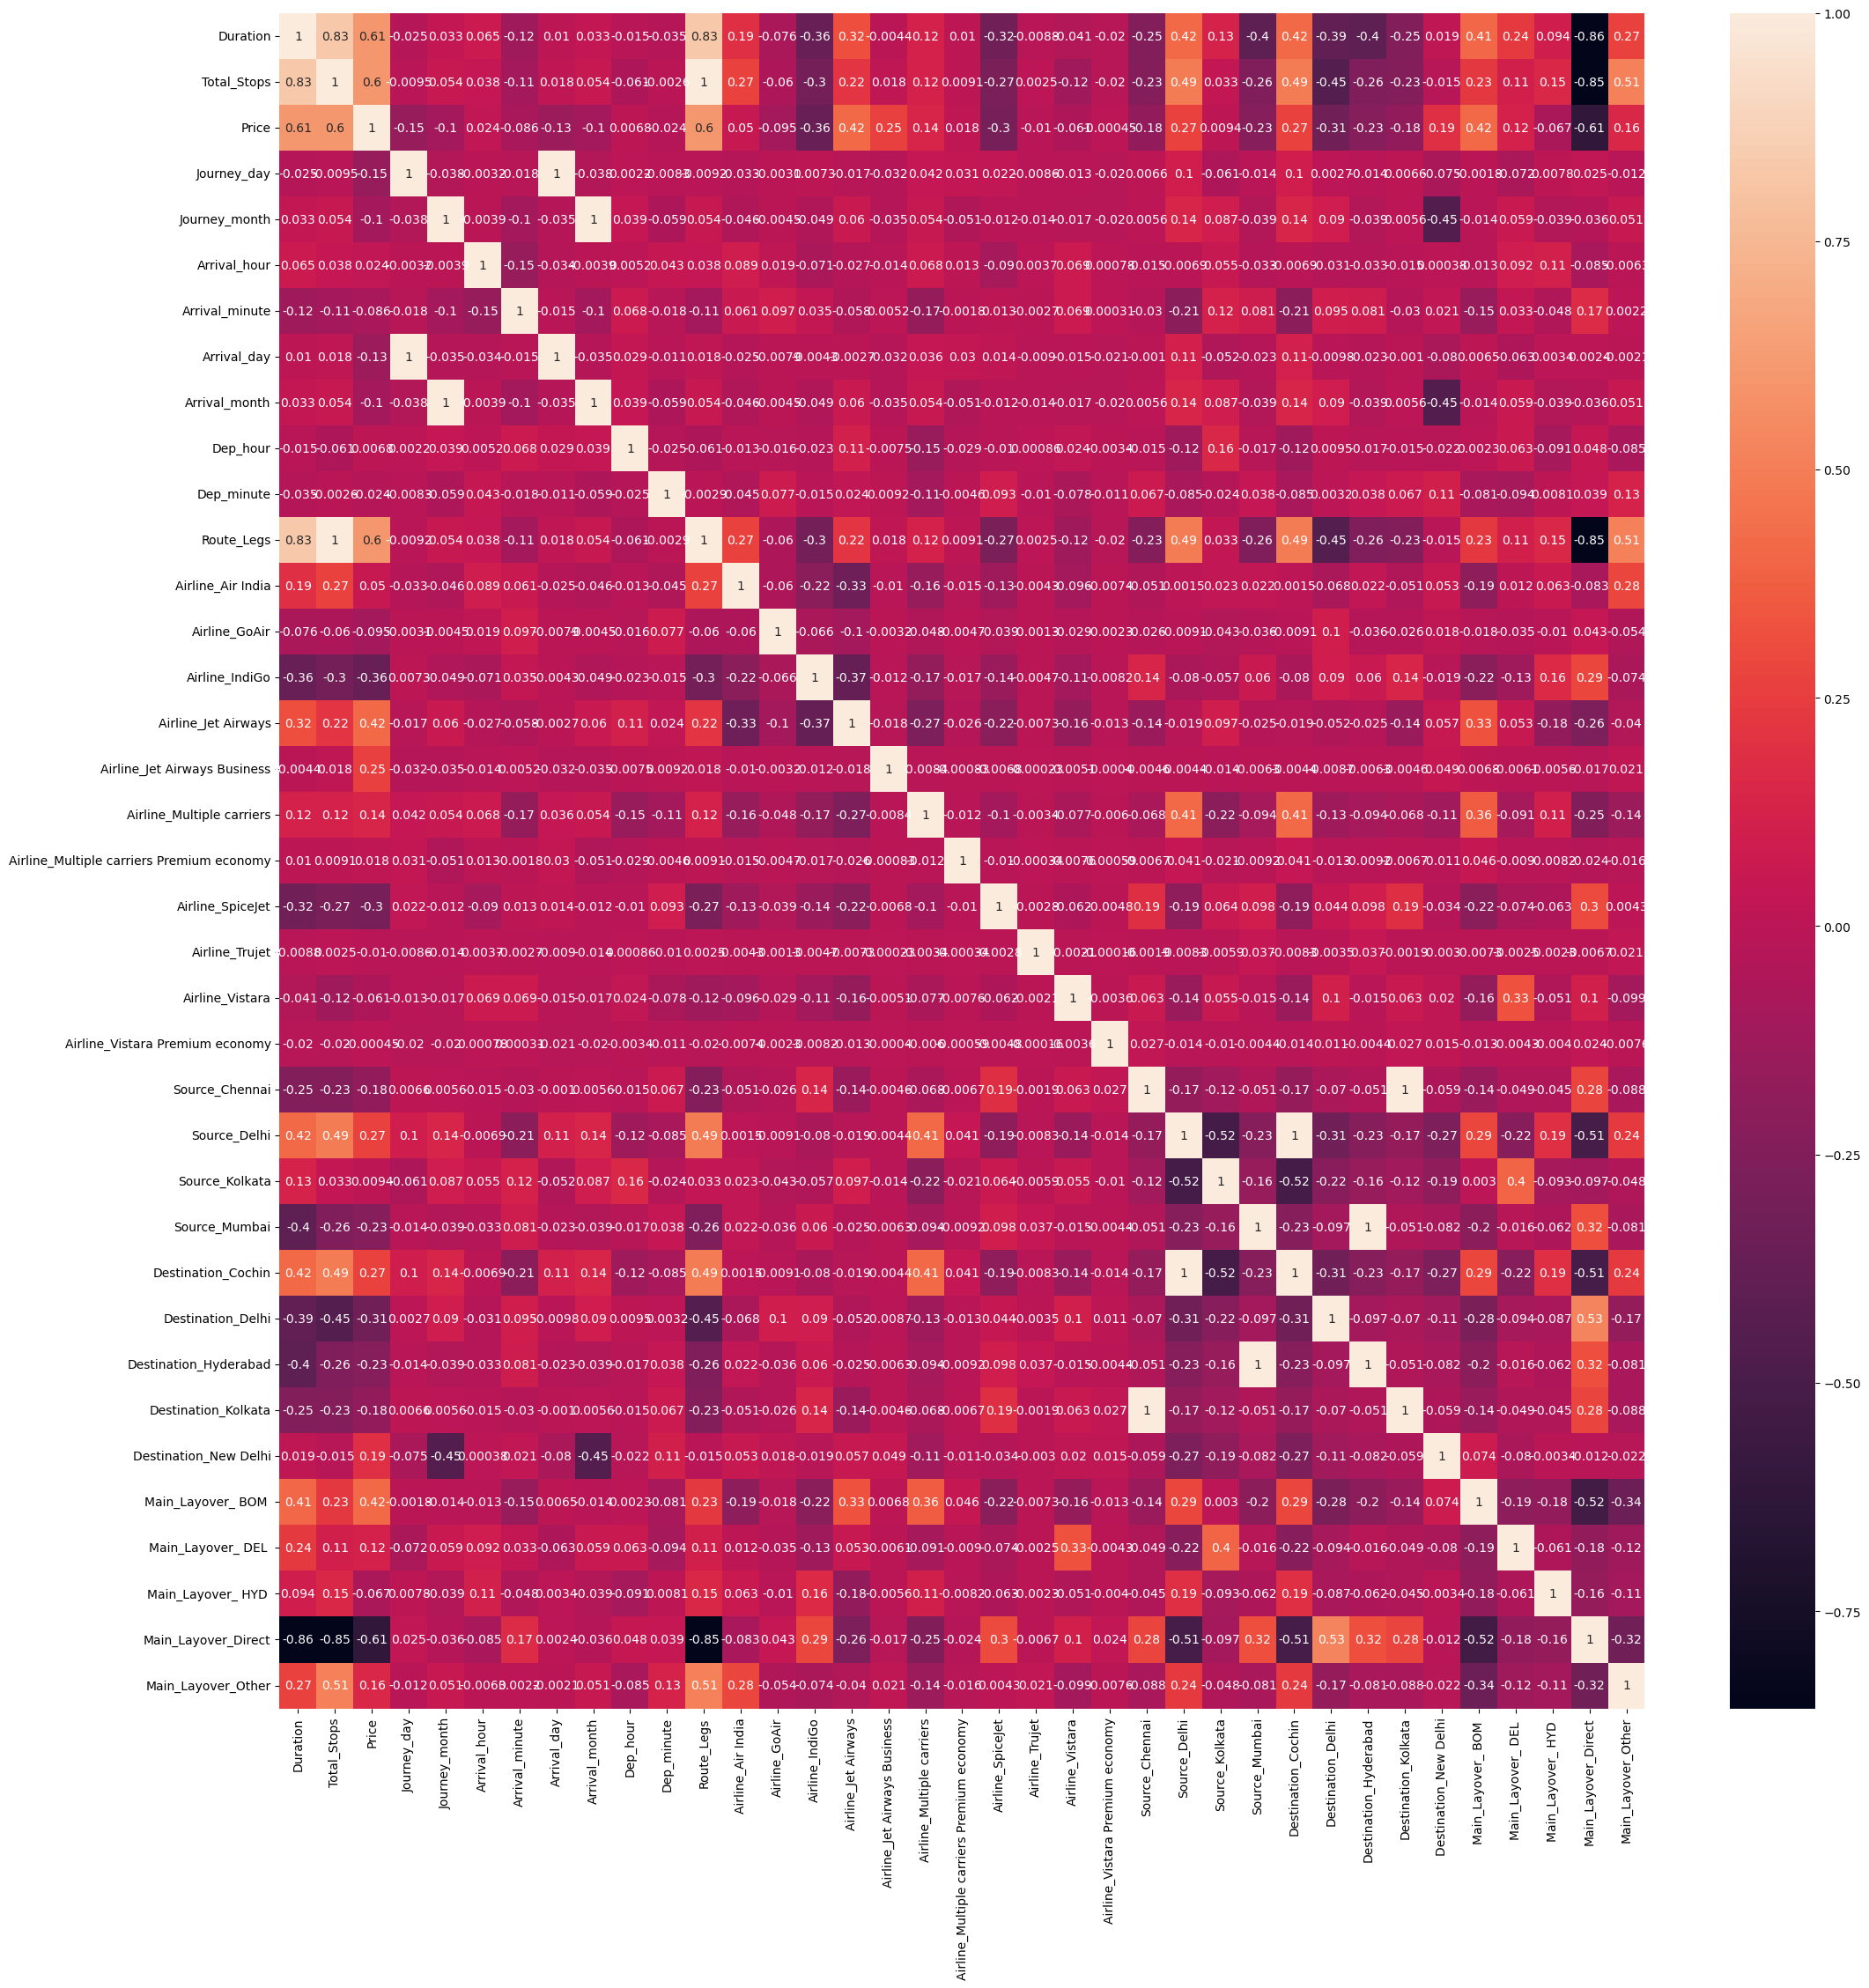

In [31]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),annot=True)

# Normalization

In [32]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Splitting Data

In [33]:
x = df.drop('Price', axis=1)
y = df['Price']

In [34]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [35]:
def adjusted_r2(r2,n,p):
    return 1-((1-r2)*(n-1)/(n-p-1))

In [36]:
n = x_test.shape[0]      # number of rows
p = x_test.shape[1]      # number of features

# Model Building

## 1) Linear Regression

In [37]:
lr = LinearRegression()
lr.fit(x_train,y_train)

y_pred=lr.predict(x_test)

print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))


MAE: 1923.559180976479
RMSE: 2760.9948227603854
R2 Score: 0.6398079456726524
Adjusted R2: 0.6336332247413266


## 2) Linear Regression With KFold Cross Validation

In [38]:
lr = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# cross-validation (R² score)
scores = cross_val_score(lr, x, y, cv=kf, scoring='r2')

print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R2 Score:", np.mean(scores))
print("Adjusted R2:", adjusted_r2(np.mean(scores), n, p))

MAE: 1923.559180976479
RMSE: 2760.9948227603854
R2 Score: 0.6413121486804352
Adjusted R2: 0.6351632140863854


## 3) Support Vector Regressor

In [39]:
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

svr.fit(x_train, y_train)

y_pred = svr.predict(x_test)


print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

MAE: 1749.2966142447067
RMSE: 2899.3842448316254
R2 Score: 0.6027951955195228
Adjusted R2: 0.5959859702998574


## 4) Support Vector Regressor With Hyperparameter Tuning

In [163]:
model=SVR()

param_dist = {
    'C': np.logspace(-2, 3, 50),
    'epsilon': np.linspace(0.01, 0.5, 20),
    'gamma': np.logspace(-3, 1, 50),
    'kernel': ['rbf']
}

random_search = RandomizedSearchCV(
    model,
    param_dist,
    n_iter=30,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train,y_train)
best_model = random_search.best_estimator_
y_pred=best_model.predict(x_test)
print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

MAE: 1636.994306928278
RMSE: 2869.488344873772
R2 Score: 0.6109442181251015
Adjusted R2: 0.6042746904358175


## 5) Random Forest Regressor

In [164]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

MAE: 1239.3933939468589
RMSE: 1957.235818965852
R2 Score: 0.8189955492763223
Adjusted R2: 0.815892615835345


## 6) Random Forest Regressor With Hyperparameter Tuning

In [165]:
model=RandomForestRegressor()
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

random_search.fit(x_train,y_train)
best_model = random_search.best_estimator_
print(random_search.best_params_)
y_pred=best_model.predict(x_test)
print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
MAE: 1152.5138940752872
RMSE: 1835.2483838385601
R2 Score: 0.8408551298220357
Adjusted R2: 0.8381269320475563


## 7) XG Boost Regressor

In [166]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)

print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

MAE: 1151.2406005859375
RMSE: 1763.262388301866
R2 Score: 0.8530949354171753
Adjusted R2: 0.8505765628814698


## 8) XGBoost Regressor With Hyperparameter Tuning

In [167]:
model=XGBRegressor()

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

random_search.fit(x_train,y_train)
best_model = random_search.best_estimator_
print(random_search.best_params_)
y_pred=best_model.predict(x_test)
print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
MAE: 1163.7042236328125
RMSE: 1760.1600779474577
R2 Score: 0.853611409664154
Adjusted R2: 0.8511018909726824


## 9) Catboost Regressor

In [168]:
catboost = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function="RMSE",
    random_seed=42,
    verbose=0
)

catboost.fit(x_train, y_train)

y_pred = catboost.predict(x_test)

print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

MAE: 1253.0667417599486
RMSE: 1806.7936860898697
R2 Score: 0.845751811569454
Adjusted R2: 0.8431075569106447


## 10) Catboost Regressor With Hyperparameter Tuning

In [169]:
model=CatBoostRegressor()
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [300, 500, 800],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1, 2]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

random_search.fit(x_train,y_train)
best_model = random_search.best_estimator_
print(random_search.best_params_)
y_pred=best_model.predict(x_test)
print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))


0:	learn: 4346.7224695	total: 2.23ms	remaining: 1.78s
1:	learn: 4107.8811649	total: 4.03ms	remaining: 1.61s
2:	learn: 3920.6315189	total: 5.81ms	remaining: 1.54s
3:	learn: 3720.2825930	total: 7.6ms	remaining: 1.51s
4:	learn: 3546.8855264	total: 9.37ms	remaining: 1.49s
5:	learn: 3403.4370101	total: 11.1ms	remaining: 1.47s
6:	learn: 3290.3676654	total: 12.8ms	remaining: 1.45s
7:	learn: 3181.4863447	total: 14.6ms	remaining: 1.45s
8:	learn: 3098.8378344	total: 16.5ms	remaining: 1.45s
9:	learn: 3019.2422976	total: 18.2ms	remaining: 1.44s
10:	learn: 2954.7262652	total: 20.1ms	remaining: 1.44s
11:	learn: 2900.6043004	total: 21.7ms	remaining: 1.43s
12:	learn: 2855.5666622	total: 23.4ms	remaining: 1.42s
13:	learn: 2813.3493029	total: 25.1ms	remaining: 1.41s
14:	learn: 2752.6944999	total: 27ms	remaining: 1.41s
15:	learn: 2703.1124367	total: 28.8ms	remaining: 1.41s
16:	learn: 2673.9271439	total: 31.2ms	remaining: 1.44s
17:	learn: 2634.4769578	total: 33.1ms	remaining: 1.44s
18:	learn: 2599.2066031

## 11) Neural Network

In [170]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test),verbose=0)

y_pred = model.predict(x_test)

print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
MAE: 1310.354736328125
RMSE: 1891.0755537524142
R2 Score: 0.8310257196426392
Adjusted R2: 0.8281290176936558


## 12) Neural Network With Keras Tuner

In [171]:
import keras_tuner as kt

In [172]:
def build_model(hp):

    model = Sequential()

    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=512, step=32),
        activation='relu',
        input_shape=(x_train.shape[1],)   
    ))

    model.add(Dropout(
        hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    ))

    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=512, step=32),
        activation='relu'
    ))

    model.add(Dropout(
        hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
    ))

    model.add(Dense(1)) 

    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mse',
        metrics=['mae']
    )

    return model


In [173]:
tuner = kt.RandomSearch(
    build_model,
    max_trials=10,
    executions_per_trial=1,
    objective='val_loss'
)

tuner.search(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5
        )
    ],
    verbose=1
)


Reloading Tuner from .\untitled_project\tuner0.json


In [174]:
best_model = tuner.get_best_models(num_models=1)[0]

y_pred = model.predict(x_test)

print("MAE:",mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
MAE: 1310.354736328125
RMSE: 1891.0755537524142
R2 Score: 0.8310257196426392
Adjusted R2: 0.8281290176936558


## 13) Stacking Regressor

In [175]:
estimators = [('rf', RandomForestRegressor(n_estimators= 100, min_samples_split= 10, min_samples_leaf= 1, max_features= 'sqrt', max_depth= None, bootstrap= False)),
              ('catboost', CatBoostRegressor(iterations=500,learning_rate=0.05,depth=6,l2_leaf_reg=3,loss_function="RMSE",random_seed=42)),
              ('xgb', XGBRegressor(subsample = 0.8, n_estimators = 300, min_child_weight = 1, max_depth = 5, learning_rate = 0.1, gamma = 0.1, colsample_bytree = 0.7))]

In [176]:
from sklearn.ensemble import StackingRegressor

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

stack_model.fit(x_train, y_train)

y_pred = stack_model.predict(x_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
print("Adjusted R2:", adjusted_r2(r2, n, p))

MAE: 1139.3706936344322
RMSE: 1755.8267740574538
R2 Score: 0.854331288739258
Adjusted R2: 0.8518341108319311


## Report

1. Built an end-to-end **Flight Fare Prediction System** with extensive feature engineering on dates, times, routes, and durations.
2. Trained and evaluated multiple models including **Linear Regression, SVR, Random Forest, XGBoost, CatBoost, Neural Networks**, and a **Stacking Regressor**.

3. Tree-based models significantly outperformed linear and kernel-based models due to their ability to capture non-linear relationships.

4. **CatBoost and XGBoost** showed the best standalone performance, while the **Stacking Regressor achieved the highest overall generalization**.
  
5. Careful preprocessing, log transformation, cross-validation, and ensembling resulted in a **robust, production-ready regression pipeline**.

---

## Model Comparison Table

| Metric | Linear | SVR | Random Forest | XGBoost | CatBoost | Neural Network | Stacking Regressor |
|------|-------------|-------------|---------------|---------|----------|----------------|--------------------|
| **MAE** | 1923.55 | 1749.29 | 1239.39 | 1151.24 | 1253.06 | 1310.35 | 1139.37 |
| **RMSE** | 2760.99 | 2899.38 | 1957.23 | 1763.26 | 1806.79 | 1891.07 | 1755.82 |
| **R² Score** | 0.6398 | 0.6027 | 0.8189 | 0.8530 | 0.8457 | 0.8310 | 0.8543 |
| **Adjusted R²** | 0.6336 | 0.5959 | 0.8158 | 0.8505 | 0.8431 | 0.8281 | 0.8518 |

---


## Model Comparison Table (Hyperparameter-Tuned Models)

| Metric | Linear (KFold) | SVR (Tuned) | Random Forest (Tuned) | XGBoost (Tuned) | CatBoost (Tuned) | Neural Network (Tuned) | Stacking Regressor |
|------|------------------|-------------|------------------------|-----------------|------------------|------------------------|--------------------|
| **MAE** | 1923.55 | 1636.99 | 1152.51 | 1163.70 | 1132.62 | 1310.35 | 1139.37 |
| **RMSE** | 2760.99 | 2869.48 | 1835.24 | 1760.16 | 1703.90 | 1891.07 | 1755.82 |
| **R² Score** | 0.6413 | 0.6109 | 0.8408 | 0.8536 | 0.8628 | 0.8310 | 0.8543 |
| **Adjusted R²** | 0.6351 | 0.6042 | 0.8381 | 0.8511 | 0.8604 | 0.8281 | 0.8518 |

---

## Challenges Faced and Techniques Used

### 1. Mixed Date and Time Formats  
**Challenge:**  
The dataset contained inconsistent formats for `Arrival_Time` (time-only and time with date), which caused parsing errors and missing values.  

**Technique Used:**  
Applied conditional parsing using regular expressions to detect time-only values, reconstructed full datetimes using journey date, and safely parsed mixed formats with `pd.to_datetime(errors="coerce")`.

---

### 2. High Cardinality Categorical Features  
**Challenge:**  
Columns like `Route` and `Main_Layover` had many unique values, leading to potential overfitting if directly encoded.  

**Technique Used:**  
Extracted meaningful features such as `Route_Legs` and `Main_Layover`, grouped rare categories into an `"Other"` class, and applied one-hot encoding only to low-cardinality features.

---

### 3. Skewed Distribution of Duration 
**Challenge:**  
`Duration` showed heavy right skew, negatively affecting linear and neural models.  

**Technique Used:**  
Applied log transformation (`log1p`) to reduce skewness and improve model stability and convergence.

---


### 4. Overfitting During Model Training  
**Challenge:**  
Complex models like Random Forests, XGBoost, and Neural Networks showed signs of overfitting.  

**Technique Used:**  
Controlled model complexity using hyperparameter tuning, regularization, early stopping, and cross-validation to ensure better generalization.

---

### 5. Model Selection and Performance Trade-offs  
**Challenge:**  
No single model consistently performed best across all evaluation metrics.  

**Technique Used:**  
Compared multiple algorithms using MAE, RMSE, R², and Adjusted R², and finally applied a **Stacking Regressor** to combine strengths of multiple models.

---

### 6. Ensuring Reliable Evaluation  
**Challenge:**  
Single train-test split results were unstable and misleading.  

**Technique Used:**  
Implemented K-Fold Cross-Validation to obtain reliable performance estimates and reduce evaluation bias.

---

